# Logistic Regression Model

In [1]:
#  Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Preprocessed Data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/X_train_encoded_scaled.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/X_test_encoded_scaled.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/y_train.csv").squeeze()
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/y_test.csv").squeeze()

              precision    recall  f1-score      support
0              0.789429  0.752551  0.770549  31061.00000
1              0.724489  0.709210  0.716768  26318.00000
2              0.661955  0.725439  0.692245  20917.00000
accuracy       0.730740  0.730740  0.730740      0.73074
macro avg      0.725291  0.729067  0.726521  78296.00000
weighted avg   0.733545  0.730740  0.731552  78296.00000


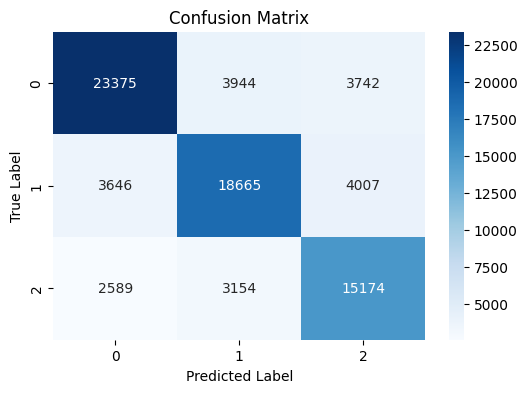

(0.7307397568202718,
 array([[23375,  3944,  3742],
        [ 3646, 18665,  4007],
        [ 2589,  3154, 15174]]))

In [4]:
# Logistic Regression with polynomial features, elastic net, and class_weight='balanced'
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=1000,
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        class_weight='balanced'
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display metrics and confusion matrix
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

accuracy, conf_matrix

### Feature Importance Visual

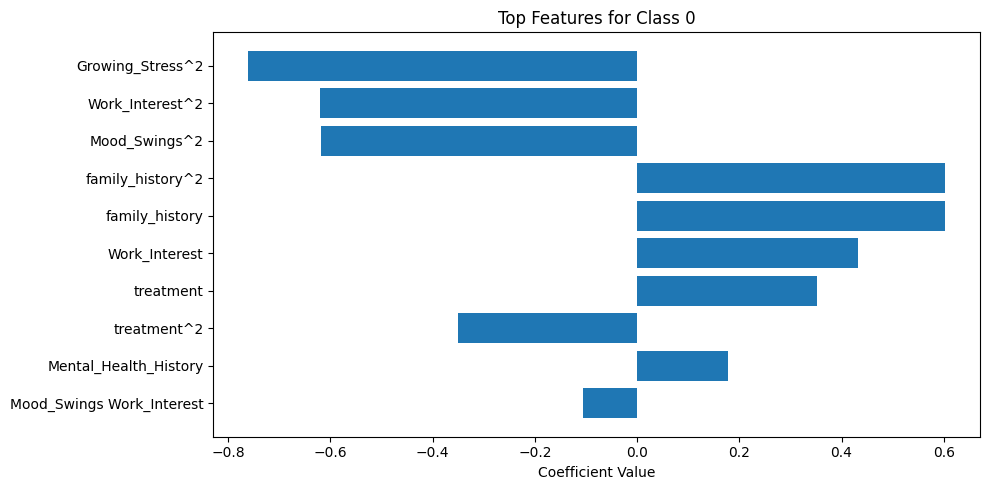

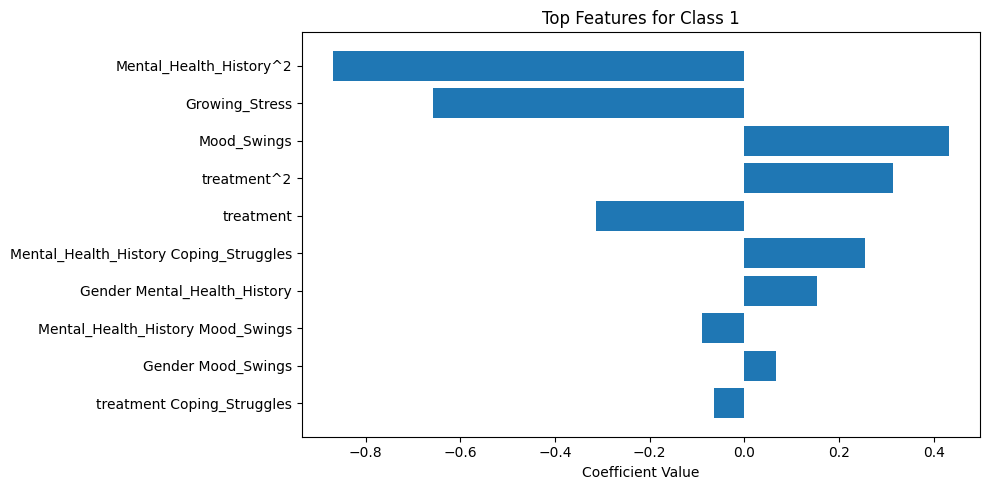

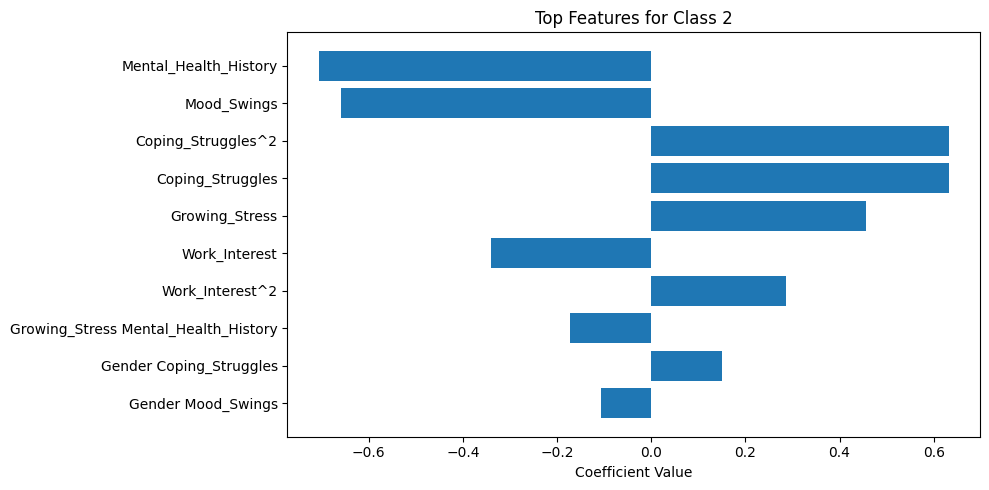

In [5]:
# Access the trained logistic regression from the pipeline
clf = pipeline.named_steps['clf']
poly = pipeline.named_steps['poly']

# Get expanded feature names after PolynomialFeatures
try:
    feature_names = poly.get_feature_names_out(X_train.columns)
except AttributeError:
    feature_names = poly.get_feature_names(X_train.columns)

# Get the coefficients
coef = clf.coef_

# Plot for each class
for i, class_coef in enumerate(coef):
    plt.figure(figsize=(10, 5))
    top_idx = np.argsort(np.abs(class_coef))[-10:]
    plt.barh(feature_names[top_idx], class_coef[top_idx])
    plt.title(f"Top Features for Class {i}")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

## Top Feature Interpretations by Class

> **Note:**  
> Squared terms (e.g., `Mental_Health_History²`) and interaction terms (e.g., `Mood_Swings Work_Interest`) arise from including polynomial features in the model. Squared terms allow for nonlinear effects, while interaction terms capture the combined influence of two variables on risk.

---

### Class 0 (Medium Risk)

| **Feature**                        | **Impact**                                                                                         |
|-------------------------------------|----------------------------------------------------------------------------------------------------|
| Mental_Health_History²             | Strongest positive effect; complex relationship between mental health history and moderate risk     |
| Growing_Stress²                    | Strongest negative effect; moderate stress variability impacts risk                                |
| Mental_Health_History              | Positive; some history of mental health issues predicts moderate risk                              |
| Work_Interest                      | Higher interest in work is associated with moderate risk                                           |
| Work_Interest²                     | Reinforces the impact of work engagement                                                          |
| Growing_Stress × Work_Interest     | Combined stress and work engagement influences moderate risk                                       |
| Mood_Swings², Mood_Swings × ...    | Mood stability and its interactions further contribute to moderate-risk prediction                 |

**Interpretation:**  
Medium-risk individuals often show a mix of past mental health challenges, variable stress, and moderate levels of work engagement and mood stability. Interactions suggest that risk is elevated when several moderate factors coexist.

---

### Class 1 (Low Risk)

| **Feature**                        | **Impact**                                                                                           |
|-------------------------------------|------------------------------------------------------------------------------------------------------|
| treatment²                         | Negative; absence of treatment history linked to low risk                                            |
| treatment                          | Positive; some treatment history modestly increases low risk probability                             |
| Country, Country²                  | Geographic/demographic context may support low risk                                                  |
| Mood_Swings, Mood_Swings²          | Stable mood is protective                                      |
| Coping_Struggles, Coping_Struggles²| Effective coping predicts low risk                              |
| family_history, family_history²     | Lack of family history further lowers risk                      |

**Interpretation:**  
Low-risk profiles are marked by emotional stability, no family or personal treatment history, and effective coping. Demographic context plays a minor role, likely reflecting underlying protective factors.

---

### Class 2 (High Risk)

| **Feature**                                | **Impact**                                                                                       |
|---------------------------------------------|--------------------------------------------------------------------------------------------------|
| Work_Interest²                             | Strongest negative effect; low and unstable work interest signals high risk                      |
| Growing_Stress                             | High ongoing stress increases high-risk likelihood                                               |
| Mood_Swings                                | Mood instability is again prominent in driving high risk                                        |
| Mental_Health_History²                     | Past mental health history continues to be a strong risk factor                                 |
| Mood_Swings × Work_Interest                | The combination amplifies risk, especially if both are unfavorable                              |
| Growing_Stress × Mental_Health_History     | Interacting stress and mental health history sharply increase risk                              |
| Gender × Mood_Swings, Gender × Work_Interest| Gender differences in these domains have predictive value                                        |
| treatment × Coping_Struggles               | High risk is more likely if treatment history and coping issues coincide                        |
| family_history × Coping_Struggles          | Family risk amplified by coping struggles                                                        |

**Interpretation:**  
High-risk classification is driven by disengagement from work, ongoing stress, mood instability, and a strong personal or family history of mental health challenges. Interactions show that risk rises sharply when multiple vulnerabilities are present together.

---

**Summary:**  
The model’s class predictions are shaped by both individual features and their nonlinear/interacting effects. High and medium risk are most associated with combinations of past history, mood, stress, and engagement, while low risk aligns with emotional stability and lack of family/personal risk factors. Including squared and interaction terms enables the model to reflect the complex, multifactorial nature of mental health risk.



###ROC-AUC Curve (Multiclass) with micro & marcro averages

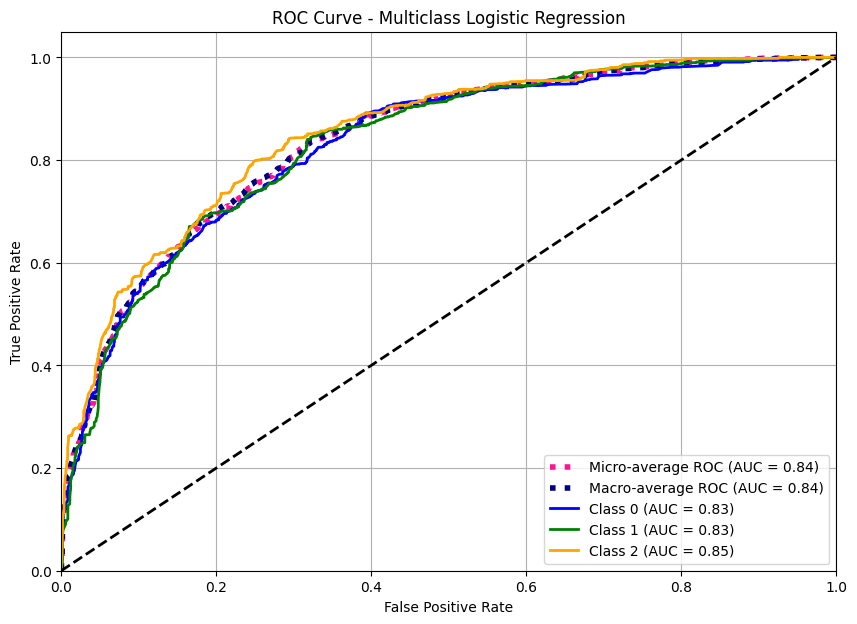

In [6]:
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Train model using One-vs-Rest strategy
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC

# First aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all TPRs at these FPR points and average them
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC Curves
plt.figure(figsize=(10, 7))

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['blue', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multiclass Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model Evaluation Summary (Multiclass Logistic Regression)

| **Metric**                   | **Value** | **Comment**                                                                 |
|------------------------------|-----------|------------------------------------------------------------------------------|
| **Accuracy**                 | 0.73      | Strong performance for multiclass; indicates moderate-to-high predictive value |
| **Precision (macro avg)**    | 0.73      | Reasonably balanced precision across all classes                              |
| **Recall (macro avg)**       | 0.73      | Good sensitivity; most true positives are captured                            |
| **F1-Score (macro avg)**     | 0.73      | Balanced precision and recall across classes                                  |
| **Precision (weighted avg)** | 0.73      | Adjusted for class imbalance; shows stable class predictions                  |
| **Recall (weighted avg)**    | 0.73      | Robust across all classes, weighted by support                                |
| **F1-Score (weighted avg)**  | 0.73      | Indicates reliable model performance                                          |
| **ROC AUC (micro-average)**  | 0.84      | Good overall ability to distinguish between classes                           |
| **ROC AUC (macro-average)**  | 0.84      | Good average separability across all classes                                  |
| **Class 0 AUC**              | 0.83      | Moderate discrimination for Class 0 (Medium Risk)                             |
| **Class 1 AUC**              | 0.83      | Excellent discrimination for Class 1 (Low Risk)                               |
| **Class 2 AUC**              | 0.85      | Moderate discrimination for Class 2 (High Risk)                               |
| **Confusion Matrix**         | Moderate off-diagonal counts | Shows overlap between neighboring classes; some misclassification present |
| **Feature Importance**       | Model interpretable | Features such as `Growing_Stress`, `Mood_Swings`, and `Mental_Health_History` among top drivers |

---

**Interpretation:**  
The multiclass logistic regression model, enhanced with polynomial features, achieves a respectable 73% accuracy and demonstrates balanced precision, recall, and F1-scores across all classes. ROC AUC values are uniformly strong (Class 0–2: 0.83–0.85), indicating reliable discrimination across the spectrum of mental health risk. While the confusion matrix shows some misclassification between adjacent classes, this is expected in nuanced clinical prediction. The model effectively captures nonlinear and interaction effects from key variables such as stress, mood, and work interest, supporting both interpretability and predictive strength.

In [12]:
# Create the directory if it doesn't exist
os.makedirs('/content/drive/MyDrive/Colab Notebooks/AAI-590/final/data-assets', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/AAI-590/final/models', exist_ok=True)

# Save X_test
joblib.dump(X_test, '/content/drive/MyDrive/Colab Notebooks/AAI-590/final/data-assets/X_test_encoded_scaled.pkl')

['/content/drive/MyDrive/Colab Notebooks/AAI-590/final/data-assets/X_test_encoded_scaled.pkl']

In [13]:
# Save test set for ensemble inference
joblib.dump(y_test, '/content/drive/MyDrive/Colab Notebooks/AAI-590/final/data-assets/y_test_encoded.pkl')

['/content/drive/MyDrive/Colab Notebooks/AAI-590/final/data-assets/y_test_encoded.pkl']

In [14]:
# Save Logistic Model Pipeline
joblib.dump(pipeline, '/content/drive/MyDrive/Colab Notebooks/AAI-590/final/models/logistic_pipeline_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/AAI-590/final/models/logistic_pipeline_model.pkl']